<a href="https://colab.research.google.com/github/wisdomscode/AI-Lab-Deep-Learning-PyTorch/blob/main/AI_Lab_Project_5_4__Medical_Data_In_Spain_Web_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Web Application Using Streamlit

We'll be developing some of the individual parts of the web app in this Jupyter Notebook before transferring them to a separate `.py` file. Let's start by importing what we'll need.

### Defining Models

Next, we'll define the GAN models that a user will be able to select from. We'll use the `medigan` library which contains many pre-trained generative adversarial networks that can create synthetic medical images. You can read more about medigan [here](https://github.com/RichardObi/medigan), including a list of available models [here](https://github.com/RichardObi/medigan?tab=readme-ov-file#available-models). Note that some models are very large and may cause the server to crash.

**Task 5.4.1:** Add another `medigan` model to the `model_ids` list.
> We recommend using "00019_PGGAN_CHEST_XRAY" to help ensure you successfully complete this task and achieve results that closely match your instructor's.

In [ ]:
model_ids = [
    "00001_DCGAN_MMG_CALC_ROI",
    "00002_DCGAN_MMG_MASS_ROI",
    "00003_CYCLEGAN_MMG_DENSITY_FULL",
    "00004_PIX2PIX_MMG_MASSES_W_MASKS",
    # New model
    "00019_PGGAN_CHEST_XRAY",
]

# Check number of models
assert len(model_ids) == 5, "Add another model"

# Check that each item in model_ids is valid
for m_id in model_ids:
    assert m_id in Generators().list_models()
else:
    print(f"All {len(model_ids)} models are valid!")

#output
All 5 models are valid!


### Moving Code to a Python File

The Streamlit framework expects all the code to be in a Python file, not a Jupyter Notebook. We'll need to move our code to a `.py` file. The `app.py` file has sections for all the elements we'll need. Right now, move the following elements over to `app.py`:

- All the imports, except `import streamlit as st` which is already provided.
- The `model_ids` list as is.


**Task 5.4.2:** Fill in the `app.py` file with imports and `model_ids` list.

In [ ]:
# Copy the imports and `model_ids` list from the cell above into the app.py

### Main Function

At the core of a Streamlit app is the `main` function, which defines the structure and behavior of the web app. Let's add a title, a model selection dropdown menu, and a selector for the number of images. We'll use Streamlit functions for each of these elements. For example, `st.sidebar.number_input` displays a numeric input widget, which you can learn more about [here](https://docs.streamlit.io/develop/api-reference/widgets/st.number_input). We'll use this widget to allow the user to dynamically select the num_images. The minimum number of images should be 1, and the maximum number of images could be 7. This range provides flexibility while ensuring the generation process doesn't take too long.

**Task 5.4.3:** Add values for the keyword arguments `min_value=` and `max_value=` in the `st.sidebar.number_input` function call in the `main` function.

In [ ]:
# add the minimum and maximum values to number_input

### The Main Block in Python


### The Main Block in Python

At the end of app.py, you'll find:

if __name__ == "__main__":
    ...
This code snippet, often called the 'main block' or 'main guard' in Python, checks whether the script is being run directly, rather than being imported as a module. The main block is a common part of Python scripts. It provides a clear entry point for the program, allowing the script to be both importable and executable. When the script is run directly, the code inside the block will execute. If it's imported as a module, this block is skipped, enabling reusable code without triggering the main program logic.

In our app.py, the main block should call the main() function, which presents the home elements for the app. While Streamlit runs the entire script from top to bottom, using this structure is still considered good practice. It keeps your code organized and ready for future expansion or reuse in other projects.

**Task 5.4.4:** Add a call to the `main` function in the main block.

### Running The App

Now that the core of the app is written, it's time to run it. To start the app, run `streamlit run app.py` at the command line. Since this app is running on a server, the additional argument `--browser.serverAddress 0.0.0.0` and `--server.port 9000` is required. Open a new terminal, navigate to the directory containing `app.py`, and run this command:

```bash
$ streamlit run app.py --browser.serverAddress 0.0.0.0 --server.port 9000
```

The app is now running. Although Streamlit is designed for local machines, we're running it on a server. You can ignore the default message for running it locally:

```text
Collecting usage statistics. To deactivate, set browser.gatherUsageStats to false.
```

```bash
  You can now view your Streamlit app in your browser.

  URL: http://0.0.0.0:9000
```

**Task 5.4.5:** Start the app at the terminal.

To access the Streamlit app, switch to the next tab that is named `Streamlit App` as shown in the following picture:

![](streamlit_tab.png)

**Task 5.4.6:** Navigate to the URL for the app.

In the web app, you can select the GAN model and the number of images from the dropdown menus. The app displays a 'Generate Images' button, but there is no associated functionality. If you press the 'Generate Images' button, the app will display an error message.

So let's shut the app off and implement the image generation functionality. To stop the app, press Ctrl + C in the terminal where the app process is running.

**Task 5.4.7:** Stop the app in the terminal.

### PyTorch Function

Now that the skeleton of the app is working, we can start working on the PyTorch elements. The `torch_images` function is responsible for loading and transforming images using PyTorch.

In [ ]:
def torch_images(num_images, model_id):
    generators = Generators()
    dataloader = generators.get_as_torch_dataloader(
        model_id=model_id,
        install_dependencies=True,
        num_samples=num_images,
        prefetch_factor=None,
    )

    images = []
    for batch_idx, data_dict in enumerate(dataloader):
        image_list = []
        for i in data_dict:
            if "sample" in i:
                sample = data_dict.get("sample")
                if sample.dim() == 4:
                    sample = sample.squeeze(0).permute(2, 0, 1)

                sample = to_pil_image(sample).convert("RGB")
                # Convert the image to a PyTorch tensor
                transform = torchvision.transforms.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                    ]
                )

                # Apply the transform to your PIL image
                sample = transform(sample)
                image_list.append(sample)

            # Preprocess the mask
            if "mask" in i:
                mask = data_dict.get("mask")
                if mask.dim() == 4:
                    mask = mask.squeeze(0).permute(2, 0, 1)
                mask = to_pil_image(mask).convert("RGB")
                mask = transform(mask)
                image_list.append(mask)

        # Organize the grid to have 'sample' images per row
        Grid = make_grid(image_list, nrow=2)

        # Change Grid tensor to be a consistent shape
        # The Grid tensor has shape [1, 128, 128, 1] in some models
        if Grid.dim() == 4:
            # Remove the singleton batch dimension
            Grid = Grid.squeeze(0)
            if Grid.size(-1) == 1:
                # Remove the singleton channel dimension (assuming grayscale)
                Grid = Grid.squeeze(-1)
            else:
                raise ValueError("Expected a single channel (grayscale) image.")

        # Convert the tensor grid to a PIL Image for display
        img = torchvision.transforms.ToPILImage()(Grid)
        images.append(img)
    return images

**Task 5.4.8:** Call the `torch_images` function to generate a single image. The existing code will display it on the screen.

In [ ]:
image = torch_images(num_images=1, model_id=model_ids[4])
image[0]

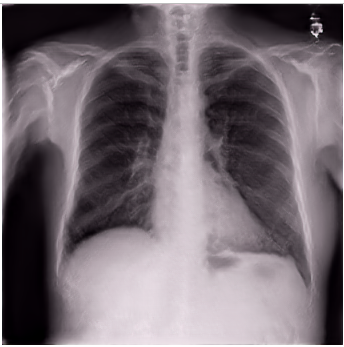

In order for the app to use the `torch_images` function, the function needs to be moved into `app.py`.  

**Task 5.4.9:** Copy the `torch_images` function from this notebook to `app.py`.

In [ ]:
# Copy the torch_images into app.py

To verify that the app is able to generate images, delete the notebook version of `torch_images`, then import and run the `torch_images` function from `app.py`.

In [ ]:
del torch_images

**Task 5.4.10:** Import `torch_images` from `app.py` to call the function and display a single image on the screen.

In [ ]:
# Import the function from the app
from app import torch_images

# Call the function
image = torch_images(num_images=1, model_id=model_ids[4])
# Display the image on the screen
image[0]

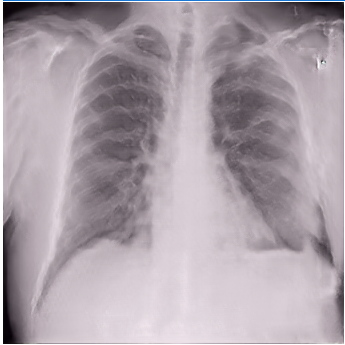

### Displaying the Images in the App

Let's integrate the PyTorch code with the Streamlit framework. In `app.py`, the `generate_images` function calls the `torch_images` function and uses Streamlit to display the resulting images in the web app.

**Task 5.4.11:** Add the parameters to the `torch_images` function call in the `generate_images` function.

Now we can add functionality to the "Generate Images" button in the app. The `st.sidebar.button` function displays a button widget, which you can learn more about [here](https://docs.streamlit.io/develop/api-reference/widgets/st.button). We'll use this widget to let the user generate images. Once the button is pressed, the app will call the `generate_images` function.

**Task 5.4.12:** Add the parameters to the `generate_images` function call in the `st.sidebar.button` function call in the `main` function.

### Running the Completed App

Let's restart the Streamlit apps by opening a terminal, navigating to the directory containing `app.py`, and run this command:

```bash
$ streamlit run app.py --browser.serverAddress 0.0.0.0 --server.port 9000
```

Switch to the tab "Streamlit App" again to preview your app.

All features of the app are now fully functional. After selecting the desired model and specifying the number of images to generate, you can click the 'Generate Images' button. While the model is generating images, you will see a 'RUNNING' message in the upper-right corner of the browser.

To stop the app, press Ctrl + C in the terminal where the app process is running.

**Task 5.4.13:** Start your app, go to your app page, and play around with it!

Great work on building a web app! You’ve successfully created a functional tool that allows users to generate images using GAN models, providing them with the flexibility to choose different models and control the number of images produced. Along the way, you learned how to use Streamlit for web development and enhanced your general Python coding skills. This project demonstrates how powerful machine learning models can be integrated into a user-friendly application. 🙌

The app.py file

In [ ]:
# Import needed libraries
import torchvision
from medigan import Generators
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
import streamlit as st

# Task 5.4.2: Fill in the app.py file with imports and model_ids list.

# Define the GAN models available in the app
model_ids = [
    "00001_DCGAN_MMG_CALC_ROI",
    "00002_DCGAN_MMG_MASS_ROI",
    "00003_CYCLEGAN_MMG_DENSITY_FULL",
    "00004_PIX2PIX_MMG_MASSES_W_MASKS",
    # New model
    "00019_PGGAN_CHEST_XRAY",
]

def main():
    st.title("MEDIGAN Medical Image Data Generator")

    # Add dropdown widget for model selection to the sidebar
    model_id = st.sidebar.selectbox("Select Model ID", model_ids)

    # Add number image selector to the sidebar
    # Task 5.4.3: Add values for the keyword arguments min_value= and max_value= in the st.sidebar.number_input function call in the main function.
    num_images = st.sidebar.number_input(
        "Number of Images", min_value=1, max_value=7, value=1, step=1
    )


    # Add generate button to the sidebar
    if st.sidebar.button("Generate Images"):
        # Task 5.4.12: Add the parameters to the generate_images function call in the st.sidebar.button function call in the main function.
        generate_images(num_images, model_id)


# Task 5.4.9: Copy the torch_images function from this notebook to app.py.
def torch_images(num_images, model_id):
    generators = Generators()
    dataloader = generators.get_as_torch_dataloader(
        model_id=model_id,
        install_dependencies=True,
        num_samples=num_images,
        prefetch_factor=None,
    )

    images = []
    for batch_idx, data_dict in enumerate(dataloader):
        image_list = []
        for i in data_dict:
            if "sample" in i:
                sample = data_dict.get("sample")
                if sample.dim() == 4:
                    sample = sample.squeeze(0).permute(2, 0, 1)

                sample = to_pil_image(sample).convert("RGB")
                # Convert the image to a PyTorch tensor
                transform = torchvision.transforms.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                    ]
                )

                # Apply the transform to your PIL image
                sample = transform(sample)
                image_list.append(sample)

            # Preprocess the mask
            if "mask" in i:
                mask = data_dict.get("mask")
                if mask.dim() == 4:
                    mask = mask.squeeze(0).permute(2, 0, 1)
                mask = to_pil_image(mask).convert("RGB")
                mask = transform(mask)
                image_list.append(mask)

        # Organize the grid to have 'sample' images per row
        Grid = make_grid(image_list, nrow=2)

        # Change Grid tensor to be a consistent shape
        # The Grid tensor has shape [1, 128, 128, 1] in some models
        if Grid.dim() == 4:
            # Remove the singleton batch dimension
            Grid = Grid.squeeze(0)
            if Grid.size(-1) == 1:
                # Remove the singleton channel dimension (assuming grayscale)
                Grid = Grid.squeeze(-1)
            else:
                raise ValueError("Expected a single channel (grayscale) image.")

        # Convert the tensor grid to a PIL Image for display
        img = torchvision.transforms.ToPILImage()(Grid)
        images.append(img)
    return images


def generate_images(num_images, model_id):
    st.subheader("Generated Images:")
    # Task 5.4.11: Add the parameters to the torch_images function call in the generate_images function.
    images = torch_images(num_images, model_id)
    for i in range(len(images)):
        # Display generated images in the web app
        st.image(
            images[i],
            caption=f"Generated Image {i+1} (Model ID: {model_id})",
            use_container_width=True,
        )


if __name__ == "__main__":
    # Task 5.4.4: Add a call to the main function in the main block.
    main()
